#  Air Quality: Design Phase

Welcome to the second lab of this course. Last week, you used exploratory data analysis to gain insight into the Bogotá air quality data obtained from the [RMCAB](http://201.245.192.252:81/home/map). In this notebook, you will work on the next stage of your project: designing your solution. 

Here are the steps you will complete in this notebook: 

1. Import Python packages
2. Load the data
3. Add location (latitude and longitude of sensor stations) to the dataframe
4. Visualize the extent and distribution of missing data
5. Visualize simple methods for estimating missing values
6. Run the nearest neighbor method to establish a baseline
7. Prepare the data to train a neural network model
8. Train and test a neural network model for estimating missing values
9. Visualize the results from your baseline model compared to the neural network
10. Estimate missing sensor measurements across all pollutants 
11. Visualize the results of filling in missing PM2.5 values
12. Optional: write the resulting dataset to a new csv file

<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Import Python packages


Run the next cell to import the Python packages you'll be using in this lab exercise. If everything goes well you should see a message when the cell has finished running that says "All packages imported successfully!".

Note the `import utils` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils.py` file to have a look.





In [1]:
# Import packages
import pandas as pd # package for reading in and manipulating data
from datetime import datetime # package for manipulating dates
from sklearn.model_selection import train_test_split # package for splitting data

import utils # utility functions defined for this lab

print('All packages imported successfully!')

All packages imported successfully!


<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Load the data

Run the next cell to load the Bogotá air quality data. This is the same step you took in the previous lab, where you are using the `pandas` package to read the csv file containing the data into a "dataframe" called `raw_data`, then modifying some of the column names and formats, and printing out the first five lines of the dataframe.

In [2]:
# Read in the data
raw_data = pd.read_csv('data/RMCAB_air_quality_sensor_data.csv')

# Modify the DateTime column format
raw_data['DateTime'] = pd.to_datetime(utils.fix_dates(raw_data, 'DateTime'), dayfirst=True)

# Rename columns from Spanish to English
raw_data = raw_data.rename(columns={'OZONO': 'OZONE'})

# print out the number of rows in the dataframe
print(f"The dataset contains {len(raw_data)} entries")

# Print out the first few lines in the dataframe
raw_data.head(5)

The dataset contains 166440 entries


,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00


<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Add location (latitude and longitude of sensor stations) to the dataframe

Run the next cell to read in another dataset containing the location of each sensor station and then add those locations as new columns to your air pollution dataset. 

**Note:** the data used here to add the location of each station includes column names in Spanish such as `Sigla` (initials), `Latitud` (latitude), `Longitud` (longitude), and with the next cell you're also renaming those columns to their English equivalent (with "station" instead of "intials").    

In [3]:
# Read in csv file containing location data and format appropriately
stations = pd.read_csv('data/stations_loc.csv')
stations = stations[['Sigla', 'Latitud', 'Longitud']]

# Rename the columns from Spanish to English
stations = stations.rename(columns={'Sigla': 'Station', 'Latitud': 'Latitude', 'Longitud': 'Longitude'})

# Parse the dates
stations['Latitude'] = stations['Latitude'].apply(utils.parse_dms)
stations['Longitude'] = stations['Longitude'].apply(utils.parse_dms)

# Add location data as extra columns to air pollution dataset
raw_data_enriched = pd.merge(raw_data, stations, on='Station', how='inner')
raw_data_enriched.head(5)

,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime,Latitude,Longitude
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00,4.532056,-74.117139
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00,4.532056,-74.117139
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00,4.532056,-74.117139
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00,4.532056,-74.117139
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00,4.532056,-74.117139


<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Visualize the extent and distribution of missing data

### Count null values

Run the next cell to perform the null value count you did in the last notebook as a reminder of how many missing values there are in each column of your dataset. 

In [4]:
# Print out a count of missing data for each column in the dataset
raw_data_enriched.isnull().sum()

PM10         20014
PM2.5        15312
NO           27664
NO2          27662
NOX          27668
CO           31238
OZONE        32132
Station          0
DateTime         0
Latitude         0
Longitude        0
dtype: int64

### Visualize missing data in a time series

Run the cell below to generate the same plot you saw near the end of the last lab, namely, pollutant values over time as measured at a particular sensor station. You can use the pulldown menus to choose different stations and pollutants. You can also use the sliders to zoom in or out on a particular range of dates. You can edit the `start_date` and `end_date` values and run the code cell again to start with a different date range. 

Try looking at different pollutants as well as different dates and sensor stations to investigate the size of gaps in the data. Note that because you have missing data, for some combinations of parameters there may be no points on your plot!

In [5]:
# Plot a time series for a particular date range, pollutant, and sensor station
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 1, 31)
utils.create_time_series_plot(raw_data, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

### Visualize the distribution of gaps in the data

Run the next cell to plot a count of gap size in hours (horizontal axis) vs. number of missing data points due to gaps of that size (vertical axis). With this plot you can get a sense of how different sized gaps in the data are contributing to your missing data problem.

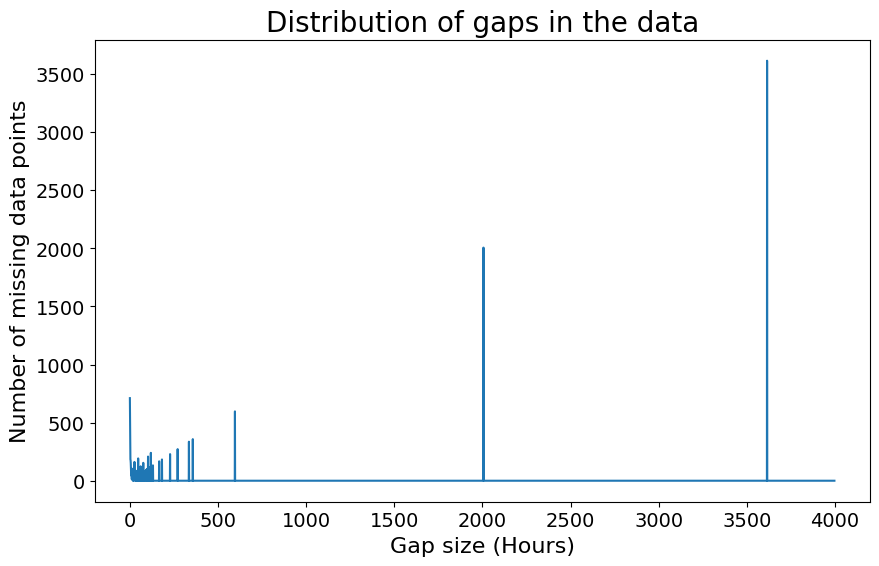

In [6]:
# Plot the distribution of gap sizes in the data
utils.plot_distribution_of_gaps(raw_data, target='PM2.5')

<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Visualize simple methods for estimating missing values

Perhaps the most straightforward way to estimate missing value in your data is to simply take the last known value in the series and use it to replace the missing value. Another option would be to use a current measurement from the nearest station (nearest neighbor method).  

Run the next cell to generate a visualization of the result of filling in missing values with either the last known value or the nearest neighbor method. 

In [7]:
# Specify the date to plot
day = datetime(2021, 5, 6)

# Create a plot to display the linear interpolation for a range of hours
utils.visualize_missing_values_estimation(raw_data_enriched, day);

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Run the nearest neighbor method to establish a baseline

With the next cell, you'll run your nearest neighbor model on simulated gaps in the PM2.5 data. The distribution of gaps you'll be testing your model on here is simulated to be similar to the distribution in the real data. In principle, the size of the gaps shouldn't matter for this method but you'll simulate the real distribution for consistency with the actual data.

You'll compute the accuracy of your baseline model by computing the [Mean Absolute Error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error). The MAE is just the average difference between your model output and the ground truth, in this case for PM2.5.

$$MAE = \frac{1}{n} \sum_{i=1}^{n}{|\rm{actual}_i - \rm{model}_i|}$$
    
Where "n" is the number of samples in the test dataset

Keep in mind that MAE is just one potential error metric you could choose to evaluate your model and, in practice, you might choose a different one (like mean squared error for example) depending on how your want to measure performance and what you aim to use your model for. Here we're using MAE because it is a simple and intuitive measurement model performance, where the error estimate is in the units of the thing you're trying to estimate, in this case, PM2.5 levels in micrograms / $\rm{m}^3$. 

Run the next cell to test the nearest neighbor method and compute MAE.

In [8]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = utils.calculate_mae_for_nearest_station(raw_data_enriched, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 8.035857704059362}


<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Prepare the data to train a neural network model

Now that you have established a baseline, you'll prepare your dataset to train and test a neural network model for estimating missing PM2.5 values. 

### Remove missing values and add columns for later use with a neural network model
To do this, you'll first remove all rows with missing values from the original dataset and then simulate gaps of different sizes in order to test your model. Before removing rows with missing values, you'll also add some extra columns to your dataset to prepare for training a neural network model. These new columns include day of the week (`day_week`) and hour of day (`hour`). The line of code defining the variable `one_hot` is converting station ID to a numerical representation to indicate which station each measurement is from. 

In [9]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week and hour of day
raw_data_for_imputing = raw_data_enriched.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  
# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)
# Print out the number of missing values in the PM2.5 column as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


### Split data into training and testing sets

In order to compare your baseline model to a neural network model, it's important to run your test on the same subset of the data. At this step, you'll separate out a testing dataset and use that to your baseline model and compare to your neural network model. 

<img src="../../../../_images/split_data.png" alt="split_data" width="400"/>

<center><b>Figure 1:</b> Splitting data into training and testing sets </center>

Run the next cell to separate out 20% of your data for testing.

In [10]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (73309, 32)
Test dataset size: (18328, 32)




    
</details>



<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Train and test a neural network model for estimating missing data.

<img src="../../../../_images/DNN.png" alt="neural_network_model" width="800"/>


Run the next cell to train and test a neural network model for estimating missing PM2.5 values. In this case, you need to train the neural network to learn how PM2.5 values are related to values for all the other pollutants as well as time of day, day of week, and station location. Note that the neural network that you will train is much larger than the one shown on the picture, as it has 64 and 32 units in the two hidden layers.

In [11]:
%%capture
# Define the features you will base your predictions on 
pollutants_list = ['PM10','PM2.5','NO','NO2','NOX','CO','OZONE']
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week', 'hour'] + list(one_hot.columns) + pollutants_except_target

# Define the neural network model architecture
model = utils.build_keras_model(input_size=len(feature_names))

# Train and test the model
model, scaler, mae = utils.train_and_test_model(feature_names, target, train_data, test_data, model)
regression_scores['neural_network_model'] = mae

Compare the **MAE** obtained using the 2 methods. This value has been obtained using the same test set so its comparable.

In [12]:
# Print out the MAE result
for model_name, model_score in regression_scores.items():
    print(model_name, ' : ', model_score)

baseline_model  :  {'MAE': 8.035857704059362}
neural_network_model  :  {'MAE': 4.090948717709141}


<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Visualize the results from your baseline model compared to the neural network.

Run the next cell to visualize the results of the baseline model and the neural network model. Use the pulldown menus to choose between different station locations and different "window" or gap sizes in hours. Use the slider to choose the start index of the window you want to investigate. You can also change the `start_date` and `end_date` values to other dates in 2021.  

In [13]:
start_date = datetime(2021, 2, 1)
end_date = datetime(2021, 2, 3)

utils.create_plot_with_preditions(data_no_missing, model, scaler, feature_names, target,  start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Estimate missing sensor measurements across all pollutants. 

With the first line of code below you will estimate missing values for all non-PM2.5 pollutants using the nearest neighbors method. With the second line, you'll use your neural network next to esimate missing values for PM2.5. The last line simply prints out the number of missing values in each column again, which should be zero if everything went well. 

In [14]:
%%capture
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = utils.impute_nontarget_missing_values_interpolate(raw_data_for_imputing, feature_names, target)
# Estimate missing PM2.5 values with 
data_with_imputed = utils.impute_target_missing_values_neural_network(raw_data_for_imputing, model, scaler, imputed_with_baseline_model, target)

In [15]:
# Print out a count of missing data for each column in the dataset with imputed values
data_with_imputed[pollutants_list].isnull().sum()

PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
OZONE    0
dtype: int64

In [16]:
# Print out a sample of the dataframe
data_with_imputed.sample(5)

,DateTime,Station,Latitude,Longitude,PM2.5,PM10,NO,NO2,NOX,CO,OZONE,PM2.5_imputed_flag,PM10_imputed_flag,NO_imputed_flag,NO2_imputed_flag,NOX_imputed_flag,CO_imputed_flag,OZONE_imputed_flag
162510,2021-07-21 06:00:00,KEN,4.625050,-74.161333,9.000000,17.575497,61.2140,23.080000,84.294000,1.466950,4.156000,None,interpolated,None,None,None,None,None
163538,2021-09-02 02:00:00,KEN,4.625050,-74.161333,15.000000,50.200000,28.0930,18.415000,46.507000,0.810150,3.993000,None,None,None,None,None,None,None
84816,2021-09-07 00:00:00,SCR,4.572553,-74.083814,7.000000,7.000000,0.4930,5.838000,6.331000,0.224500,16.288000,None,None,None,None,None,None,None
136415,2021-07-28 23:00:00,COL,4.737194,-74.069472,2.200000,9.100000,1.6790,23.998000,25.677000,0.319130,7.656000,None,None,None,None,None,None,None
133393,2021-03-25 01:00:00,COL,4.737194,-74.069472,19.261356,35.404444,19.6122,11.911733,31.523933,1.083603,2.607836,neural network,interpolated,interpolated,interpolated,interpolated,interpolated,interpolated


You can see that the flag columns include different values: `None` where there is original data, `'neural network'` where the values were imputed with the neural network and `'interpolated'` where the values were interpolated.



<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Visualize the results of filling in missing PM2.5 values

You can use the flag columns you recorded above to distinguish between original and estimated data, and you can visualize this by running the cell below.

In [17]:
# Define a start and end date and visualize missing values that have been imputed
start_date = datetime(2021, 3, 1)
end_date = datetime(2021, 4, 30)
utils.create_time_series_plot(data_with_imputed, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

<br><br><br><br>

<div class="ui blue inverted segment"> 
</div>

## Optional: write the resulting dataset to a new csv file

Finally, you can save the data to a new csv file for use in the next stage of the project. In this case, the data will be provided to you in the next lab so you don't need to save it here, but we've included the line of code below to show you how you can write the data to file. If you uncomment the code below (remove the #) you can run the cell and then click on the Jupyter icon above to see the new csv file in your folder with the rest of the lab contents. 

In [18]:
# data_with_imputed.to_csv('full_data_with_imputed_values.csv')